# Countershape Autospacer

Hit `Runtime > Run All` and look at the hamburgefonsiv at the bottom!

In [3]:
#%matplotlib notebook

# Spacing parameters:

# Minimum ink-to-ink distance. Increase this if "VV" is too close.
bare_minimum = 2
# Serif smoothing. Doesn't make a huge difference but increase if you have prominent serifs.
serif_smoothing = 2

# These are pairs with trusted spacings. We derive the parameters from these.
# If you don't like the result, space a pair manually and add it to this list.
key_pairs = ["HH","OO","HO","OH","EE","AV"]

In [4]:
#!wget -q -O CrimsonRoman.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Roman.otf?raw=true
#!wget -q -O Tinos-Italic.ttf https://github.com/jenskutilek/free-fonts/raw/master/Tinos/TTF/Tinos-Italic.ttf
#!wget -q -O PTSerif-Italic.ttf https://github.com/divspace/pt-serif/raw/master/fonts/pt-serif/pt-serif-italic.ttf
#!wget -q -O Crimson-SemiboldItalic.otf https://github.com/skosch/Crimson/raw/master/Desktop%20Fonts/OTF/Crimson-SemiboldItalic.otf
#!pip install --upgrade git+git://github.com/simoncozens/tensorfont.git

In [5]:
import numpy as np
from scipy.signal import convolve
from tensorfont import Font,GlyphRendering
import scipy
import string
import matplotlib.pyplot as plt
import sys
from skimage.util import pad
from skimage.morphology import convex_hull_image
from scipy.ndimage import distance_transform_edt, distance_transform_cdt

0.5700934579439252
0.19402985074626866


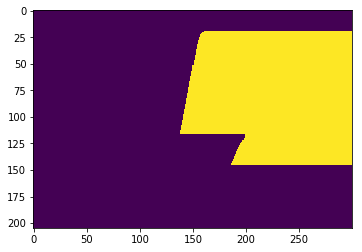

In [7]:
factor = 90
# f = Font("CrimsonRoman.otf", 34 * factor)
# f = Font("Tinos-Italic.ttf", 34 * factor)
# f = Font("OpenSans-Regular.ttf", 34 * factor)
# f = Font("PTSerif-Italic.ttf", 34 * factor)
f = Font("Crimson-SemiboldItalic.otf", factor)


box_height = f.full_height_px
box_width = 300# int(1.5 * f.m_width)
theta = f.italic_angle * np.pi/180
alpha = (90 - f.italic_angle) * np.pi/180
# print(f.scale_factor)

def rotated_mgrid(rot_rad=0):
    """Generate a meshgrid and rotate it by RotRad radians."""
    rotation = np.array([[np.cos(rot_rad),  np.sin(rot_rad)],
                          [-np.sin(rot_rad), np.cos(rot_rad)]])
    hh = box_height / 2.
    bw = box_width / 2.
    y, x = np.mgrid[-hh:hh, -bw:bw] + 1.
    return np.einsum('ji, mni -> jmn', rotation, np.dstack([x, y]))

fx, fy = rotated_mgrid(0)

from functools import lru_cache

#@lru_cache(maxsize=None)
def kernel(width, height):
    s = width
    a = np.log(1.5*np.pi)/(s*(1+np.abs(theta)))
    lim = max(np.log(2*np.pi)/a, 1.)
    lkernel = -np.sin(np.exp(a*fx)) * np.where(fx<lim, 1, 0) * a**2 * np.exp(-(fy/height)**2/2.)
    rkernel = -np.sin(np.exp(-a*fx)) * np.where(fx>-lim, 1, 0) * a**2 * np.exp(-(fy/height)**2/2.)
    lkernel *= lkernel > 0
    rkernel *= rkernel > 0
    return rkernel

# Various caches
_counters = {}
def counters(glyph):
    if glyph in _counters: return _counters[glyph]
    fg = f.glyph(glyph)
    _counters[glyph] = fg.as_matrix(normalize=True).with_padding_to_constant_box_width(box_width).mask_ink_to_edge()
    return _counters[glyph]

kernel_size = serif_smoothing
@lru_cache()
def lshifted_counter(glyph,amount, reftop, refbottom):
    fg = f.glyph(glyph).as_matrix()
    fg = GlyphRendering.init_from_numpy(fg._glyph,convolve(fg,kernel(kernel_size,kernel_size),mode="same") > 250)
    conc = 0
    if fg.discontinuity(contour="right") > 0:
        conc = 1-fg.right_face()
    padded = fg.with_padding_to_constant_box_width(box_width)
    padded[0:reftop,:]   = 0
    padded[refbottom:,:] = 0
    padded = padded.reduce_concavity(conc)
    c = scipy.ndimage.shift(padded, (0,amount), mode="nearest")
    l,r = GlyphRendering.init_from_numpy(glyph, c).mask_ink_to_edge()
    r = (r>0).astype(np.uint8)
    return r


@lru_cache()
def rshifted_counter(glyph,amount,reftop, refbottom):
    fg = f.glyph(glyph).as_matrix()
    fg = GlyphRendering.init_from_numpy(fg._glyph,convolve(fg,kernel(kernel_size,kernel_size),mode="same") > 250)
    conc = 0
    if fg.discontinuity(contour="left") > 0:
        conc = 1-fg.left_face()
    padded = fg.with_padding_to_constant_box_width(box_width)
    padded[0:reftop,:]   = 0
    padded[refbottom:,:] = 0
    padded = padded.reduce_concavity(conc)
    c = scipy.ndimage.shift(padded, (0,amount), mode="nearest")
    l,r = GlyphRendering.init_from_numpy(glyph, c).mask_ink_to_edge()
    l = (l>0).astype(np.uint8)
    return l

lshifted_counter.cache_clear()
rshifted_counter.cache_clear()

def gaussian(center_x, center_y, width_x, width_y, rotation):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
#     print("Gaussian with parameters",center_x, center_y, width_x, width_y, rotation)
    center_x = box_width/2 - center_x
    center_y = box_height/2 - (box_height - center_y)
    center_x = center_x * np.cos(rotation) - center_y * np.sin(rotation)
    center_y = center_x * np.sin(rotation) + center_y * np.cos(rotation)

    xp = fx * np.cos(rotation) - fy * np.sin(rotation)
    yp = fx * np.sin(rotation) + fy * np.cos(rotation)
    g = np.exp(
        -(((center_x-xp)/width_x)**2+
          ((center_y-yp)/width_y)**2)/2.)
    return np.flip(g,axis=1)

l = f.glyph("L").as_matrix().discontinuity(contour="right")
print(l)
print( f.glyph("L").as_matrix().right_face())

# c = rshifted_counter("L",50,0.5)
d = lshifted_counter("L",0,20,150)
plt.imshow(d)
# plt.imshow(gaussian(100,50,5,20,0.17))
# print(np.sum(c))

The function `pair_areas` is the meat of the procedure. It determines the area of the counterspace between a pair of glyphs.

In [8]:
from scipy import ndimage
from scipy.ndimage.interpolation import rotate

def pair_areas(l, r, options, dist = None,reference="HH"):
    lref, rref = [f.glyph(r) for r in reference]
    reftop = min(lref.tsb,rref.tsb)
    refbottom = min(lref.tsb+lref.ink_height, rref.tsb+rref.ink_height)

    sigmas_top    = (options["w_top"], options["h_top"])
    sigmas_bottom = (options["w_bottom"], options["h_bottom"])
    sigmas_center = (options["w_center"], options["h_center"])

    kernel_dimensions = (options["serif_smoothing"], options["serif_smoothing"])
    top_strength = options["top_strength"]
    bottom_strength = options["bottom_strength"]
    center_strength = options["center_strength"]

    if dist is None:
          dist = f.pair_distance(l,r)
    shift_l, shift_r = f.shift_distances(l,r,dist)

    redgeofl = (box_width - f.glyph(l).ink_width) / 2.0 + f.glyph(l).ink_width + shift_l
    ledgeofr = box_width-((box_width - f.glyph(r).ink_width) / 2.0 + f.glyph(r).ink_width) + shift_r
    center = (redgeofl + ledgeofr)/2 - f.minimum_ink_distance(l, r) / 2
    midline = (reftop+refbottom)/2 - box_height/2

    # This mask ensures we only care about the area "between" the
    # glyphs, and don't get into e.g. interior counters of "PP"
    l_shifted = lshifted_counter(l,shift_l,reftop,refbottom)
    r_shifted = rshifted_counter(r,shift_r,reftop,refbottom)
    ink_mask =  (l_shifted > 0) & (r_shifted > 0)
    ink_mask[0:reftop,:] = 0
    ink_mask[refbottom:,:] = 0

    # If the light was from the middle, this is where it would be
    union = np.array(((l_shifted + r_shifted) * ink_mask) > 0)
#     print("Union before light:", np.sum(union))
    y_center, x_center = ndimage.measurements.center_of_mass(union)
    if np.isnan(y_center) or np.isnan(y_center): return union
# #     print(x_center,y_center)
#     # Find top and bottom light sources
    top_x = int((x_center) + (y_center) / np.tan(alpha))
    bottom_x = int((x_center) - (box_height-y_center) / np.tan(alpha))
    top_y = 0
    bottom_y = box_height

    # Blur the countershape slightly
    union = union > 0
#     union = convolve(union,kernel(kdims[0],kdims[1]),mode="same")
    
    # Now shine two lights from top and bottom  
    toplight = gaussian(top_x,top_y,sigmas_top[0],sigmas_top[1],theta)
    bottomlight = gaussian(bottom_x,bottom_y,sigmas_bottom[0],sigmas_bottom[1],theta)
    centerlight = gaussian(x_center,y_center,sigmas_center[0],sigmas_center[1],theta)

    fnonz = False
    for i in range(reftop+1,refbottom):
        if fnonz:
            toplight[i,:] = toplight[i,:] * (toplight[i-1,:] > 0) * (union[i,:] > 0)
        else:
            if np.any(toplight[i,:] > 0):
                fnonz = True
    fnonz = False
    for i in range(refbottom-1,reftop,-1):
        if fnonz:
            bottomlight[i,:] = bottomlight[i,:] * (bottomlight[i+1,:] > 0) * (union[i,:] > 0)
        else:
            if np.any(toplight[i,:] > 0):
                fnonz = True

        #     print("Total light:", np.sum( top_strength * toplight + bottomlight ))
    union =  centerlight * center_strength * union + union * bottomlight * bottom_strength + union * ( top_strength * toplight)
    return union

# plt.imshow(pair_areas("Y","Z",options))

In [9]:
from scipy.optimize import least_squares, fminbound, minimize
bounds_for = {
    "w_center": (5,25),
    "h_center": (50,200),
    "w_top": (5,25),
    "h_top": (50,200),
    "w_bottom": (5,50),
    "h_bottom": (50,200),
    "center_strength": (1,1),
    "top_strength": (0.25,1),
    "bottom_strength": (0.25,1),
}
def solve_for(*, variables, strings, guess, options):
    reference = strings.pop(0)
    bounds = [bounds_for[v] for v in variables]
    print(bounds)
    def comparator(o):
        for ix,var in enumerate(variables):
            options[var] = o[ix]
#         print(o)
        HH = np.sum(pair_areas(reference[0],reference[1],options))
        err = []
        for s in strings:
            val = np.sum(pair_areas(s[0],s[1],options))
            err.append( ( val - HH) / HH )
        err = np.sum(np.array(err) ** 2)
#         print(err)
        return err
    result = minimize(comparator,guess,method="TNC",
                      options = {"disp": True}, bounds=bounds)
    for ix,var in enumerate(variables):
        options[var] = result.x[ix]
    return options

options = solve_for(
    variables = ["h_center","w_center","center_strength","h_top","w_top","top_strength","h_bottom","w_bottom","bottom_strength"],
    strings = key_pairs,
    options = {
        "w_top": 1,
        "w_bottom": 1,
        "h_top": 1,
        "h_bottom": 1,
        "w_center": 50,
        "top_strength": 1,
        "bottom_strength": 1,
        "serif_smoothing": 0,
    },
    guess = [200,200,5,200,200,5,200,200,5]
)
print(options)

[(50, 200), (5, 25), (1, 1), (50, 200), (5, 25), (0.25, 1), (50, 200), (5, 50), (0.25, 1)]
{'w_top': 25.0, 'w_bottom': 50.0, 'h_top': 114.7851272520847, 'h_bottom': 200.0, 'w_center': 25.0, 'top_strength': 0.2591137006015358, 'bottom_strength': 0.365167116428417, 'serif_smoothing': 0, 'h_center': 200.0, 'center_strength': 1.0}


Test this procedure to make sure it's working. If it works well, then the area found for the two comparison pairs will be very similar to the area for the reference pair. If not, the parameters need tuning.

HH as percent of HH = 100.000000
UR as percent of HH = 104.412362
VJ as percent of HH = 117.262982
VH as percent of HH = 117.837147


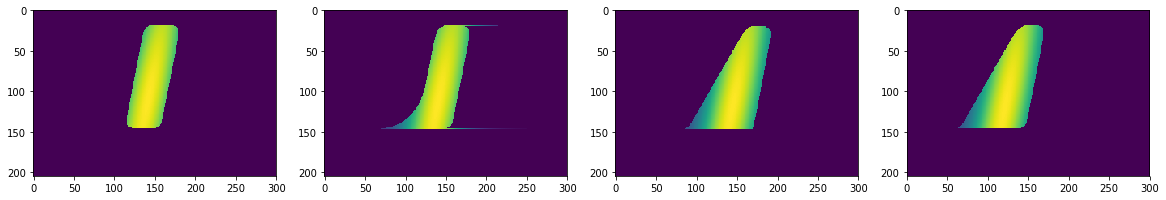

In [10]:
strings = ["HH", "UR","VJ","VH"]
reference = strings[0]

fig, ax = plt.subplots(1,len(strings),figsize = (20,20))
matrices = [ pair_areas(s[0],s[1],options,reference=reference) for s in strings]

for i in range(0,len(strings)):
    ax[i].imshow(matrices[i])
# # ax[1].imshow(ls)
    print("%s as percent of %s = %f" % (strings[i], reference, 100*np.sum(matrices[i])/np.sum(matrices[0])))


Now we have the area function, we can build our spacer. The idea is to start at the bare minimum distance (generally you don't want glyphs to touch, but have a bit of breathing space between them) and then move the glyphs steadily outwards until their area meets the reference. The graph will show the way the area changes will distance.

In [11]:
pdd = {} # This will contain our resulting "spacing table"
mse = 0

def space(l,r, plot=False):
    reference = "HH"
    if l in string.ascii_lowercase and r in string.ascii_lowercase:
      reference = "nn"
    if l in string.ascii_uppercase and r in string.ascii_lowercase:
      reference = "nn" # NOTE!
    if l in string.ascii_lowercase and r in string.ascii_uppercase:
      reference = "nn"
    u_good = pair_areas(reference[0],reference[1], options, reference=reference)
    expected = f.pair_distance(l,r)
    mid = f.minimum_ink_distance(l, r)
#     mad = f.maximum_ink_distance(l, r)
    u_good = np.sum(u_good)
#     print("Target: %i" % u_good)
#     print("MID = %i, MAD = %i" % (mid,mad))
    xs = []
    ys_union = []
    ys_intersection = []
    rv = None
    peak = -1
    peak_idx = -1
    goneover = False

    for n in range(-mid+bare_minimum,60,1):
        u = pair_areas(l,r,options,dist=n, reference=reference)
        xs.append(n)
        u = np.sum(u)
        ys_union.append(u)
#         print(n,np.sum(u))
#         ys_intersection.append(np.sum(i))
        if n == expected and plot:
            plt.plot([n,n],[0,u],color='r')
        if u > u_good:
            goneover = True
            rv = n
            break
        if u > peak:
            peak = u
            peak_idx = n
#     print("rv is", rv)
    if plot:
        plt.plot(xs,ys_union)
        plt.plot([min(xs),40],[u_good,u_good],color='g')
    if rv is None:
#         return peak_idx
      return -mid+bare_minimum
    return rv

def compare(s, plot=False):
    global pdd
    found = space(s[0],s[1],plot=plot)
    good = f.pair_distance(s[0],s[1])
    pdd[(s[0],s[1])] = found
    if abs(found-good) > 5:
        ok="!!!"
    else:
        ok=""
    print("%s: pred=%i true=%i %s" % (s,found/f.scale_factor,good/f.scale_factor, ok))

from itertools import tee
def pairwise(iterable):
  a, b = tee(iterable)
  next(b, None)
  return zip(a, b)

def fill_pdd(s):
  for l,r in pairwise(s):
    if not (l,r) in pdd: compare((l,r))

In the following graphs, the blue line is the union area when glyphs are set at a given distance. The green line is the target area (so the computed space is the X coordinate where green and blue intersect). The red line is the spacing value from the font.

XX: pred=-104 true=-129 


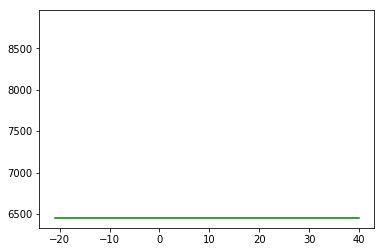

In [12]:
compare("XX",plot=True)
# for s in ["BB","OO","RD","FO","CO"]:
#     compare(s)

AV can often work fine if set tighter than designers have set it. Remember that all this stuff is pretty subjective anyway. Let's try a few more pairs.

In [ ]:
for s in ["XX","DV","VF","FA","AV","tx", "VV","no","ga","LH"]:
    compare(s, plot=True)

XX: pred=-104 true=-129 
DV: pred=29 true=28 
VF: pred=-124 true=-104 
FA: pred=-164 true=-130 !!!


Here's what all those pairs look like when set together as a string. The number is the mean squared error between the values in the font and the values derived from the autospacer. (Lower is better.) But the real proof is by eye.

('H', 'O'): pred=-28 true=-42 
('O', 'H'): pred=-28 true=-28 
('H', 'A'): pred=-280 true=-280 
('V', 'X'): pred=-280 true=-310 
('X', 'D'): pred=-140 true=-182 
('V', 't'): pred=-252 true=-165 !!!
('x', 'V'): pred=-56 true=154 !!!
('V', 'n'): pred=-308 true=-224 !!!
('o', 'g'): pred=14 true=-42 


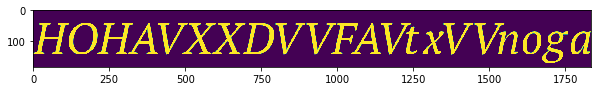

In [123]:
fig2 = plt.figure(figsize = (10,10))
pairstring = "HOHAVXXDVVFAVtxVVnoga"
# pairstring = "nin"
fill_pdd(pairstring)
fig2.add_subplot(111).imshow(np.clip(f.set_string(pairstring,pdd),None,400))

And here's a hamburgefonsiv

('A', 'H'): pred=28 true=28 
('H', 'L'): pred=-182 true=-210 
('L', 'V'): pred=14 true=21 
('V', 'O'): pred=-182 true=-180 
('O', 'Y'): pred=14 true=110 !!!
('Y', 'X'): pred=-280 true=-310 
('X', 'G'): pred=-112 true=-84 
('G', 'A'): pred=-154 true=-154 
('V', 'J'): pred=-308 true=-294 
('J', 'G'): pred=-28 true=0 
('G', 'S'): pred=84 true=0 !!!


Text(0.5, 1.0, 'original')

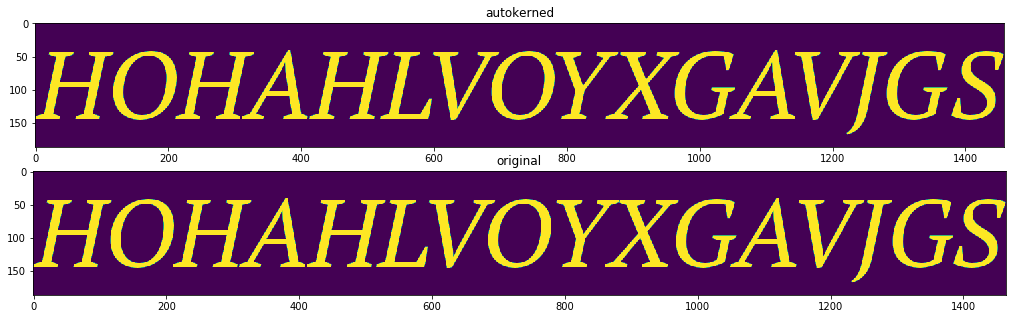

In [124]:
teststring = "HOHAHLVOYXGAVJGS"
fill_pdd(teststring)

fig, ax = plt.subplots(2,1,figsize=(20,5))
ax[0].imshow(np.clip(f.set_string(teststring,pdd),None,400))
ax[0].set_title("autokerned")
ax[1].imshow(np.clip(f.set_string(teststring),0,255))
ax[1].set_title("original")

## Space all the things!

This will take a long time.

In [ ]:
for l in string.ascii_letters:
    print(l, end=' ', file=sys.stdout, flush=True)
    for r in string.ascii_letters:
        pdd[(l,r)] = space(l,r)
print("")

In [ ]:
print("    " + ("   ".join(string.ascii_lowercase)))
for l in string.ascii_lowercase:
    print(l, end=' ', file=sys.stdout, flush=True)
    for r in string.ascii_lowercase:
        print("%3i" % (float(pdd[(l,r)]) / f.scale_factor), end=' ', file=sys.stdout, flush=True)
    print("")


In [ ]:
from fontTools.ttLib import TTFont
ttfont = TTFont(f.filename)
if not "glyf" in ttfont:
    print("Truetype only. :-(")

def set_sidebearings(g,new_lsb,new_rsb):
    old_width, old_lsb = ttfont["hmtx"].metrics[g]
    old_rsb = old_width - max([f[0] for f in ttfont["glyf"][g].coordinates])
    ink_width = old_width - (old_lsb+old_rsb)
    ttfont["hmtx"].metrics[g] = (new_lsb+ink_width+new_rsb, new_lsb)
    ttfont["glyf"][g].coordinates -= (old_lsb-new_lsb,0)

# # Trash sidebearings
# for g in string.ascii_letters:
#     set_sidebearings(g,0,0)

# # Fill kern table
# del ttfont["GPOS"]
# for l in string.ascii_letters:
#     for r in string.ascii_letters:
#         ttfont["kern"].kernTables[0][l,r] = int(float(pdd[(l,r)]) / f.scale_factor)

# ttfont.save("autokerned-"+f.filename)


In [ ]:
from fontTools.ttLib import TTFont
ttfont = TTFont(f.filename)
if not "glyf" in ttfont:
    print("Truetype only. :-(")

def derive_sidebearings(keyglyph,glyphset):
    keyspace = int(pdd[(keyglyph,keyglyph)] / (f.scale_factor * 2))
    set_sidebearings(keyglyph, keyspace, keyspace)
    print("Key glyph: %s = %i - %i" % (keyglyph, keyspace, keyspace))
    for g in glyphset:
        lsb = int(pdd[(keyglyph,g)] / f.scale_factor) - keyspace
        rsb = int(pdd[(g,keyglyph)] / f.scale_factor) - keyspace
        print("%s = %i - %i" % (g,lsb,rsb))
        set_sidebearings(g,lsb,rsb)

derive_sidebearings("H", string.ascii_uppercase) # Use O if H is very swashy
derive_sidebearings("n", string.ascii_lowercase)

del ttfont["GPOS"]
for l in string.ascii_letters:
    width_l, lsb_l = ttfont["hmtx"].metrics[l]
    rsb_l = width_l - max([f[0] for f in ttfont["glyf"][l].coordinates])
    for r in string.ascii_letters:
        width_r, lsb_r = ttfont["hmtx"].metrics[r]
        currentspace = rsb_l + lsb_r
        desiredspace = int(pdd[(l,r)] / f.scale_factor)
        ttfont["kern"].kernTables[0][l,r] = desiredspace - currentspace        

ttfont.save("autokerned-"+f.filename)


In [ ]:
print(pdd["n","n"] / (f.scale_factor*2))
width_l, lsb_l = ttfont["hmtx"].metrics["n"]
rsb_l = width_l - max([f[0] for f in ttfont["glyf"]["n"].coordinates])
print(rsb_l)